We manually labelled a random sample of skills extracted from job adverts and which ESCO skills they mapped to. This allows us to get a sense of:
1. How well skills are extracted
2. How well skills are mapped to ESCO

In [1]:
import pandas as pd

import ast

from ojd_daps_skills.getters.data_getters import get_s3_resource, load_s3_data, save_to_s3
from ojd_daps_skills import bucket_name, logger

In [2]:
s3 = get_s3_resource()

In [3]:
quality_data_file_name = "escoe_extension/outputs/evaluation/skills_sample_quality_manually_tagged_251122.csv"

In [4]:
hardcoded_file_name = "escoe_extension/outputs/data/skill_ner_mapping/hardcoded_ojo_esco_lookup.json"

In [5]:
quality_data = load_s3_data(s3, bucket_name, quality_data_file_name)

In [6]:
hardcode_data = load_s3_data(s3, bucket_name, hardcoded_file_name)

In [7]:
hardcoded_ojo_skills = set([h['ojo_skill'] for h in hardcode_data.values()])

In [8]:
len(hardcode_data)

73

## Hardcode fix
- If any skill in the tagged data is in the hardcode data then remove it from this evaluation

In [13]:
quality_data['skill'] = quality_data['skill'].map(lambda x: ast.literal_eval(x))
quality_data.rename(
    columns={
        "good_skill? (excellent = 2, ok = 1, bad = 0)": "good_skill?",
        "good_match? (excellent = 2, ok = 1, bad = 0)": "good_match?"
    }, inplace=True)

quality_data['ojo_skill'] = quality_data['skill'].map(lambda x: x[0])
quality_data['esco_skill'] = quality_data['skill'].map(lambda x: x[1][0])
quality_data = quality_data[~quality_data['ojo_skill'].isin(hardcoded_ojo_skills)].reset_index(drop=True)

In [14]:
quality_data['skill_code'] = quality_data['skill'].map(
    lambda x: "skill" if len(x[1][1]) > 10 else (
        "skill_level_3" if ((len(x[1][1]) >=6)and  (x[1][1][0]=="S")) else (
        "skill_level_2" if ((len(x[1][1]) >=4)and  (x[1][1][0]=="S")) else (
        "A" if "A" in x[1][1] else (
            "T" if "T" in x[1][1] else (
                "K" if "K" in x[1][1]else x[1][1])) ) ) 
    ))
quality_data['not_matched'] = quality_data['skill'].map(lambda x: len(x[1][1])<=3)

In [15]:
print(len(quality_data))
quality_data = quality_data[quality_data['good_skill?']!="?"]
quality_data = quality_data[quality_data['good_match?']!="?"]
print(len(quality_data))

187
183


## Results

In [16]:
quality_data_matched = quality_data[~quality_data['not_matched']]
len(quality_data_matched)

172

In [17]:
not_matched = quality_data['not_matched'].value_counts()
print(not_matched)
not_matched/not_matched.sum()

False    172
True      11
Name: not_matched, dtype: int64


False    0.939891
True     0.060109
Name: not_matched, dtype: float64

In [18]:
good_skill = quality_data['good_skill?'].value_counts()
good_skill/good_skill.sum()

2    0.725275
1    0.192308
0    0.082418
Name: good_skill?, dtype: float64

In [19]:
good_match = quality_data_matched['good_match?'].value_counts()
good_match/good_match.sum()

2    0.526316
1    0.304094
0    0.169591
Name: good_match?, dtype: float64

In [20]:
good_skill_match = quality_data_matched[['good_skill?', 'good_match?']].value_counts(sort=False).reset_index()
good_skill_match.rename(columns={0:'count'}, inplace=True)
good_skill_match

,good_skill?,good_match?,count
0,0,0,9
1,0,1,1
2,1,0,9
3,1,1,16
4,1,2,7
5,2,0,11
6,2,1,35
7,2,2,83


## By which part of the ESCO taxonomy the skill was mapped to

In [21]:
low_level_quality_data_matched = quality_data_matched[quality_data_matched['skill_code'].isin(['skill', 'skill_level_3'])]

In [22]:
low_level_quality_data_matched[['skill_code','good_skill?', 'good_match?']].value_counts(sort=False)

skill_code     good_skill?  good_match?
skill          1            1               8
                            2               4
               2            0               1
                            1              19
                            2              67
skill_level_3  0            0               5
                            1               1
               1            0               6
                            1               6
                            2               3
               2            0               8
                            1              11
                            2              11
dtype: int64

In [119]:
quality_data_matched['good_match_num?'] = quality_data_matched['good_match?'].apply(lambda x: {'0':0, '1':1, '2':2}.get(x))
quality_data_matched.groupby('skill_code')['good_match_num?'].mean()

skill_code
A                1.625000
K                0.166667
T                1.000000
skill            1.707071
skill_level_2    0.333333
skill_level_3    0.901961
Name: good_match_num?, dtype: float64

In [126]:
quality_data_matched.groupby('skill_code')['good_match_num?'].count()

skill_code
A                 8
K                 6
T                 1
skill            99
skill_level_2     6
skill_level_3    51
Name: good_match_num?, dtype: int64

In [128]:
print([v[1][1] for v in quality_data_matched[quality_data_matched['skill_code']=='A']['skill']])

['A1.4.0', 'A1.16.0', 'A1.8.0', 'A1.12.3', 'A1.7.0', 'A1.12.3', 'A1.2.0', 'A1.12.0']


In [129]:
print([v[1][1] for v in quality_data_matched[quality_data_matched['skill_code']=='K']['skill']])

['K0031', 'K0416', 'K0532', 'K041', 'K0222', 'K0417']


In [130]:
print([v[1][1] for v in quality_data_matched[quality_data_matched['skill_code']=='T']['skill']])

['T2.2']


## Visualisation

In [85]:
good_skill_match_rep = good_skill_match.replace({'0': '0 - Bad', '1': '1 - OK', '2': '2 - Excellent'}, )
good_skill_match_piv = good_skill_match_rep.pivot(index='good_skill?', columns='good_match?', values='count')
good_skill_match_piv

good_match?,0 - Bad,1 - OK,2 - Excellent
good_skill?,,,
0 - Bad,9.0,1.0,NaN
1 - OK,9.0,16.0,7.0
2 - Excellent,11.0,35.0,83.0


In [86]:
color_mapper = {'0 - Bad': '#EB003B', '1 - OK': '#97D9E3', '2 - Excellent': '#18A48C'}

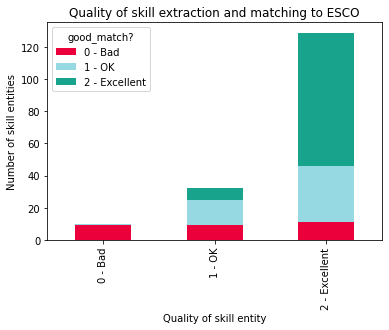

In [98]:
good_skill_match_piv.plot.bar(stacked=True, color = color_mapper.values(),
                              ylabel="Number of skill entities",
                              title="Quality of skill extraction and matching to ESCO",
                              xlabel="Quality of skill entity");

## Examples of poor skills and matches

In [47]:
print("Skill entity quality examples")
print("\nExcellent skill entities:")
print(quality_data[quality_data['good_skill?']=='2']['ojo_skill'].tolist()[0:5])
print("\nOK skill entities:")
print(quality_data[quality_data['good_skill?']=='1']['ojo_skill'].tolist()[0:5])
print("\nBad skill entities:")
print(quality_data[quality_data['good_skill?']=='0']['ojo_skill'].tolist()[0:5])

Skill entity quality examples

Excellent skill entities:
['Cleaning and sharpening hand tools and kitchen utensils', 'Provide pastoral support', 'InDesign templates', 'Strong communicator and influencer', 'Document and implement verifiable process improvements']

OK skill entities:
['Superior planning', 'meeting and exceeding the specific service levels required', 'Risk  - (Credit, Regulatory, Liquidity, Market, Analysts-SAS', 'arranging site  visits over the phone so you will need to have a desire to promote the company products', 'act as the bridge between Business and Technology']

Bad skill entities:
['Membership of an appropriate Professional body', 'REWARDS', 'General terms and conditions', 'Committee minutes and annual Board', 'Residents and Relatives are actively involved in the development of the service']


In [48]:
print("Skill matches quality examples")
print("\nExcellent skill matches:")
print(quality_data_matched[quality_data_matched['good_skill?']=='2'][['ojo_skill', 'esco_skill']].values.tolist()[0:5])
print("\nOK skill matches:")
print(quality_data_matched[quality_data_matched['good_skill?']=='1'][['ojo_skill', 'esco_skill']].values.tolist()[0:5])
print("\nBad skill matches:")
print(quality_data_matched[quality_data_matched['good_skill?']=='0'][['ojo_skill', 'esco_skill']].values.tolist()[0:5])

Skill matches quality examples

Excellent skill matches:
[['Cleaning and sharpening hand tools and kitchen utensils', 'maintain kitchen utensils clean'], ['Provide pastoral support', 'assisting and supporting co-workers'], ['InDesign templates', 'making patterns and templates'], ['Strong communicator and influencer', 'personal skills and development'], ['Document and implement verifiable process improvements', 'documenting technical designs, procedures, problems or activities']]

OK skill matches:
[['Superior planning', 'perform planning'], ['Risk  - (Credit, Regulatory, Liquidity, Market, Analysts-SAS', 'performing risk analysis and management'], ['arranging site  visits over the phone so you will need to have a desire to promote the company products', 'promoting products, services, or programs'], ['detailing pupil achievement, monitor strengths, and weaknesses, inform planning and recognise the level at which the pupil is achieving', 'monitoring and evaluating the performance of indi